In [1]:
%load_ext jupyter_black

# extract transfer load

io is the input and output of information

io is part of both the extract and load process

python provides a io module

In [2]:
import io

# when working with io operations, some memory allocation happens
# after the operation is completed the file should be closed.
# fileIO may be used to write the contents to a text file.
file = io.FileIO("hello.txt", "w")
file.close()
# BytesIO might be used to download some data and write the contets of the download to a memory buffer
buffer = io.BytesIO()
buffer.close()

In [3]:
# this is an exampple of a context manager
# some classes or functions may offer the utility
# of a context manager to manage these type of operations
with io.BytesIO() as buffer:
    assert not buffer.closed

# once the NOTE SCOPE returns to the level from where the code was ran
# the context manager will close the file
assert buffer.closed

In [4]:
from contextlib import contextmanager
# below is the rough implementation of a context manager
# using the context manager decorator function
@contextmanager
def my_buffer():
    buffer = io.BytesIO()
    try:
        yield buffer
    finally:
        buffer.close()


with my_buffer() as b:
    assert not b.closed

assert b.closed





In [46]:
from typing import Callable
def my_dec(func:Callable):
    def wraps():
        return "hello " + func()
    return wraps

@my_dec
def hello():
    return "world"
hello()

'hello world'

In [34]:
import numpy as np 

a = np.random.randint(0,100,100)

mask = (a > 25) & (a < 75 )

i_was_inverted = (~mask != mask)
assert all(i_was_inverted)

a[mask], a[~mask]

(array([47, 45, 72, 50, 58, 59, 43, 63, 46, 37, 52, 46, 59, 41, 50, 70, 28,
        29, 41, 35, 53, 41, 34, 64, 68, 41, 46, 27, 34, 57, 40, 66, 34, 52,
        29, 73, 71, 69, 44]),
 array([92,  9,  3, 84, 78, 90, 93, 99, 11, 78, 77, 81, 21, 14, 92, 93, 90,
        87, 24, 81,  4, 13, 94, 97, 75, 10, 15, 11,  7, 93,  3, 99,  5,  5,
        75, 84, 89, 86, 22, 23, 20, 91, 22, 91,  0,  1, 97, 20,  4, 77,  7,
         8,  3, 90, 89, 12, 99,  2, 95, 76, 24]))

In [56]:
import os
from datetime import datetime, date
from pathlib import Path
from typing import Literal
import shutil


ECCODES_DIR = "/usr/include/eccodes"
os.environ["ECCODES_DIR"] = ECCODES_DIR
import requests
import cfgrib
import numpy as np
import xarray as xr

class Response:
    def raise_for_status(self,):...
    status_code=200

r = Response()
r.status_code
r.raise_for_status




def download(url: str, folder: Path) -> Path:
    # true or false condition
    idx = url.endswith(".idx")
    # request to get a response from the server
    r = requests.get(url, stream=not idx)
    # in the event our request failed raise an http exception
    r.raise_for_status()
    # creating a local file name by splitting the url
    _, filename = r.url.rsplit("/", maxsplit=1)
    # creating New Path object to write the contents
    destination = folder / filename
    # using a context manager to open and close the file
    with destination.open("wb") as fdst:
        # the idx file is basicly just text so we can just write the content to the file object
        if idx:
            fdst.write(r.content)
        else:
            # the grib file can be kind of large, the shutil module
            # provides some utility for saving large files
            shutil.copyfileobj(r.raw, fdst)
    # last return the path object from the function so it can be read in the transfer stage
    return destination


def extract(target_date: date | datetime, path: Path) -> Path:
    url = f"https://nomads.ncep.noaa.gov/pub/data/nccf/com/557ww/prod/557ww.{target_date:%Y%m%d}/GLOBAL.grib2.{target_date:%Y%m%d}00.0000"
    # print(url)
    # first download the idx file
    download(url + ".idx", path)
    # # the download the grib file
    file = download(url, path)
    # # return the path object to the grib file
    return file



FilterLevel = Literal[
    "meanSea", "unknown", "heightAboveGroundLayer", "heightAboveSeaLayer", "hybrid"
]


def transfer(
    file: Path,
    type_of_level: FilterLevel = "heightAboveSeaLayer",
) -> xr.Dataset:
    """
    filter_by_keys={'typeOfLevel': 'meanSea'}
    filter_by_keys={'typeOfLevel': 'unknown'}
    filter_by_keys={'typeOfLevel': 'heightAboveGroundLayer'}
    filter_by_keys={'typeOfLevel': 'hybrid'}
    filter_by_keys={'typeOfLevel': 'heightAboveSeaLayer'}
    """

    ds = xr.open_dataset(
        file,
        engine="cfgrib",
        backend_kwargs={"filter_by_keys": {"typeOfLevel": type_of_level}},
    )
    return ds


def load():
    ...


def main(start: date | datetime, path=Path.cwd().parent / "data"):
    if not path.exists():
        path.mkdir()

    # file = extract(start, path)
    (file,) = (f for f in path.glob("*") if not f.suffix == ".idx")
    ds = transfer(file, "heightAboveGroundLayer")
    return ds
    # print(ds)
    # load()


if __name__ == "__main__":
    ds = main(date.today())
ds
# ds = ds.expand_dims({"validTime": [ds["valid_time"].values]}).drop(
#     ["time", "heightAboveGroundLayer", "step", "valid_time"]
# )
# ds.to_array()

<xarray.Dataset>
Dimensions:                 (latitude: 361, longitude: 720)
Coordinates:
    time                    datetime64[ns] ...
    step                    timedelta64[ns] ...
    heightAboveGroundLayer  float64 ...
  * latitude                (latitude) float64 90.0 89.5 89.0 ... -89.5 -90.0
  * longitude               (longitude) float64 0.0 0.5 1.0 ... 359.0 359.5
    valid_time              datetime64[ns] ...
Data variables:
    turb                    (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             57
    GRIB_centreDescription:  U.S. Air Force - Global Weather Center
    GRIB_subCentre:          4
    Conventions:             CF-1.7
    institution:             U.S. Air Force - Global Weather Center
    history:                 2022-09-07T08:07 GRIB to CDM+CF via cfgrib-0.9.1...

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

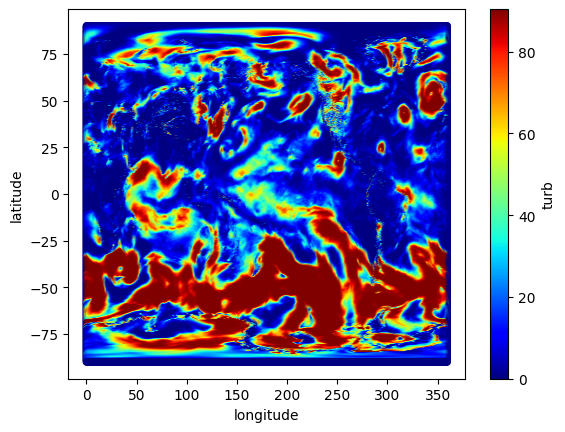

In [97]:
import matplotlib.pyplot as plt

ds.to_dataframe().reset_index().plot.scatter(
    x="longitude",
    y="latitude",
    cmap=plt.get_cmap("jet"),
    c="turb",
)

In [35]:
ds

NameError: name 'ds' is not defined

In [ ]:
import os
import sys
import shutil

import gzip
import zipfile
from pathlib import Path

text = f"""
os.path = {os.path.abspath(".")}
pathlib.Path.cwd() = {Path.cwd()}
sys.path = {sys.path}
"""
print(text)
dict(line.split("=", maxsplit=1) for line in text.split("\n") if line != "")


os.path = /home/leaver2000/afit/2022-09
pathlib.Path.cwd() = /home/leaver2000/afit/2022-09
sys.path = ['/home/leaver2000/afit/2022-09', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/opt/venv/lib/python3.10/site-packages', '/opt/venv/lib/python3.10/site-packages/IPython/extensions', '/home/leaver2000/.ipython']



{'os.path ': ' /home/leaver2000/afit/2022-09',
 'pathlib.Path.cwd() ': ' /home/leaver2000/afit/2022-09',
 'sys.path ': " ['/home/leaver2000/afit/2022-09', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/opt/venv/lib/python3.10/site-packages', '/opt/venv/lib/python3.10/site-packages/IPython/extensions', '/home/leaver2000/.ipython']"}

In [ ]:
cwd = Path.cwd()
assert cwd.is_dir() and not cwd.is_file()
# glob (/ɡlɑːb/) patterns specify sets of filenames with wildcard characters
# so in our working directory match all of the files or navigate to the parent and look for files ending with .py
# the glob method yields a generator function
tuple(cwd.glob("*")), tuple(cwd.parent.glob("*.py"))

((PosixPath('/home/leaver2000/afit/2022-09/lesson-2.2-dataclasses.ipynb'),
  PosixPath('/home/leaver2000/afit/2022-09/lesson-2.0-io.ipynb'),
  PosixPath('/home/leaver2000/afit/2022-09/lesson-3.ipynb'),
  PosixPath('/home/leaver2000/afit/2022-09/lesson-1.ipynb'),
  PosixPath('/home/leaver2000/afit/2022-09/lesson-2.3-enums.ipynb')),
 (PosixPath('/home/leaver2000/afit/app.py'),))

In [ ]:
import json

for file in Path.cwd().glob("*"):
    # the path object
    assert file.is_file()
    if ".ipynb" in file.suffixes:
        print(f"found a notebook {file}")
        # using the with key word will open the file as a context manager
        with file.open("r") as f:
            lines = f.readlines()
            print(f"it had {len(lines)} lines")
    # if not using the with key word
    # need to remember to close the file
    # otherwise we are loading tons of
    # unused data into memory
    f = file.open()
    f.close()

found a notebook /home/leaver2000/afit/2022-09/lesson-2.2-dataclasses.ipynb
it had 562 lines
found a notebook /home/leaver2000/afit/2022-09/lesson-2.0-io.ipynb
it had 114 lines
found a notebook /home/leaver2000/afit/2022-09/lesson-3.ipynb
it had 32 lines
found a notebook /home/leaver2000/afit/2022-09/lesson-1.ipynb
it had 993 lines
found a notebook /home/leaver2000/afit/2022-09/lesson-2.3-enums.ipynb
it had 447 lines


In [ ]:
from collections.abc import MutableMapping


class D(MutableMapping):
    """
    Mapping that works like both a dict and a mutable object, i.e.
    d = D(foo='bar')
    and
    d.foo returns 'bar'
    """

    # ``__init__`` method required to create instance from class.
    def __init__(self, *args, **kwargs):
        """Use the object dict"""
        self.__dict__.update(*args, **kwargs)

    # The next five methods are requirements of the ABC.
    def __setitem__(self, key, value):
        self.__dict__[key] = value

    def __getitem__(self, key):
        return self.__dict__[key]

    def __delitem__(self, key):
        del self.__dict__[key]

    def __iter__(self):
        return iter(self.__dict__)

    def __len__(self):
        return len(self.__dict__)

    # The final two methods aren't required, but nice for demo purposes:
    def __str__(self):
        """returns simple dict representation of the mapping"""
        return str(self.__dict__)

    def __repr__(self):
        """echoes class, id, & reproducible representation in the REPL"""
        return "{}, D({})".format(super(D, self).__repr__(), self.__dict__)


D(foo="Bar")
# {**D(foo="Bar")}

<__main__.D object at 0x7fd5422e6050>, D({'foo': 'Bar'})